# Download the dataset

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(house_path=HOUSING_PATH,url=HOUSING_URL):
    if not os.path.isdir(house_path):
        os.makedirs(house_path)
    tgz_path = os.path.join(house_path, "housing.tgz")
    urllib.request.urlretrieve(url,tgz_path)
    house_tgz=tarfile.open(tgz_path)
    house_tgz.extractall(house_path)
    house_tgz.close()

fetch_housing_data()

In [36]:
#All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR,LinearSVC
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.feature_selection import SelectFromModel

# Get Data

In [4]:
def load_data(house_path=HOUSING_PATH):
    csv_path=os.path.join(house_path,'housing.csv')
    return pd.read_csv(csv_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


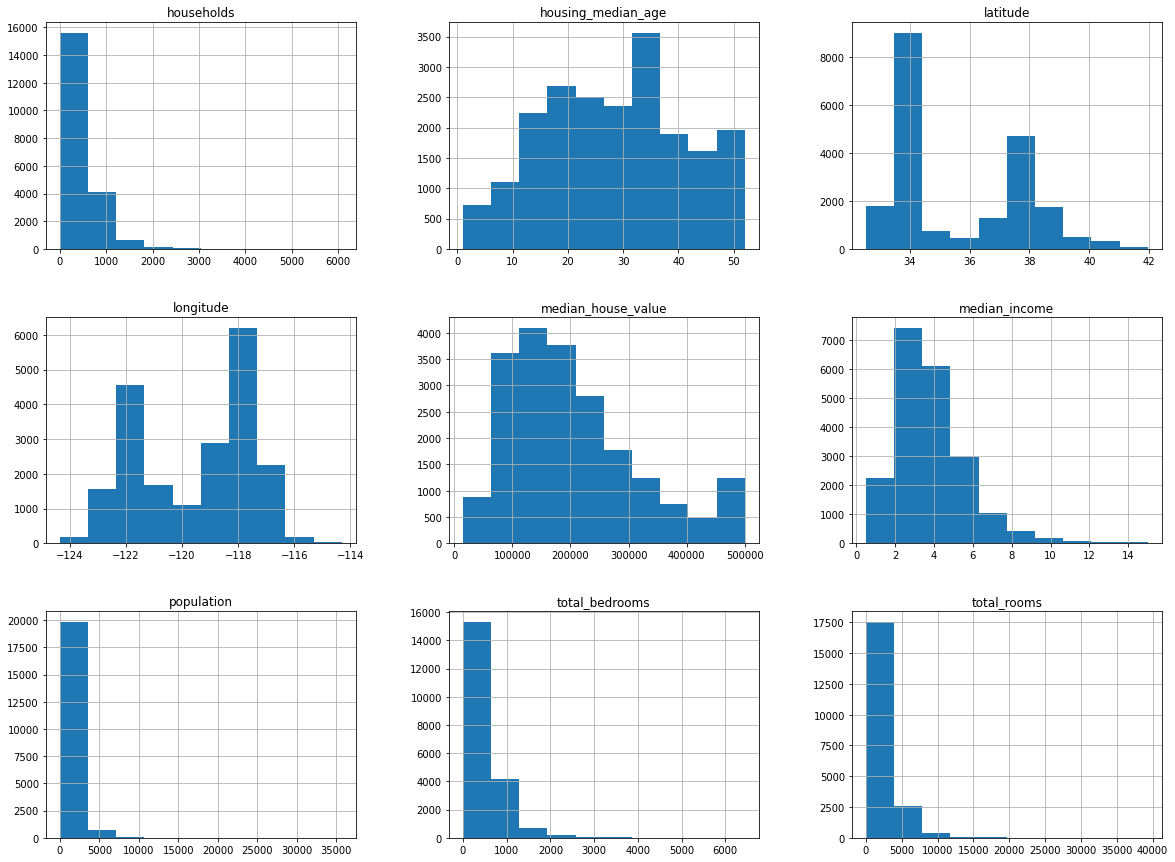

In [5]:
housing=load_data()
housing.info()
housing.hist(figsize=(20,15))
plt.show()

# Explore Data

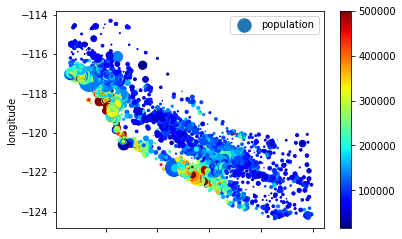

In [6]:
housing.plot(kind='scatter',x='latitude',y='longitude', label='population',
                s=housing.population/100,c=housing.median_house_value,
                cmap=plt.get_cmap('jet'),colorbar=True)
plt.legend()
plt.show()

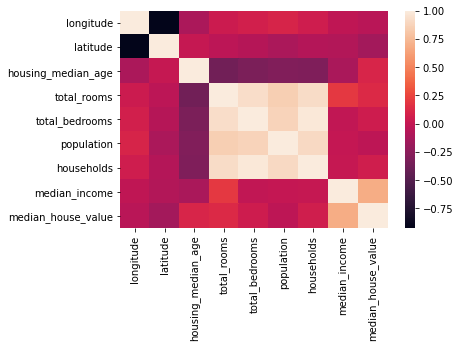

In [7]:
correlations=housing.corr()
# most_effeted=correlations['total_bedrooms'].sort_values(ascending=False)
sns.heatmap(correlations)
plt.show()

# Data Cleaning

In [8]:
housing_labels=housing['median_house_value'].copy()
housing=housing.drop('median_house_value',axis=1)

In [9]:
numeric_attrb=[col for col in housing.columns if housing[col].dtype=='float64']
category_attrb=['ocean_proximity']

In [10]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [11]:
num_pipe=Pipeline([('imp',SimpleImputer()),
    ('norm',StandardScaler())])

cat_pipe=Pipeline([('encoder',OneHotEncoder(sparse=False)),
                    ('norm',StandardScaler())])

full_pipe=ColumnTransformer([('num',num_pipe,numeric_attrb),
                             ('cat',cat_pipe,category_attrb)
                             ])

In [12]:
housing_prepared=full_pipe.fit_transform(housing)
housing_prepared.shape

(20640, 13)

# Train Model 

In [13]:
params={'kernel':['linear','rbf'],
        'C':np.arange(1,6),
        'gamma':['scale','auto']}

In [14]:
svm=SVR()
param_search=RandomizedSearchCV(svm,param_distributions=params,verbose=1,n_jobs=-1)
param_search.fit(housing_prepared,housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.8min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': array([1, 2, 3, 4, 5]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)

In [15]:
param_search.best_params_

{'C': 5, 'gamma': 'scale', 'kernel': 'linear'}

# Pipeline with feature selection and prediction

In [18]:
pred_pipeline=Pipeline([('cleaning',full_pipe),
                        ('feature_selection',SelectFromModel(LinearSVC())),
                        ('regression',SVR(kernel='linear',gamma='scale',C=5)),
                        ])

In [19]:
pred_pipeline.fit(housing,housing_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('cleaning',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imp',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                                       

In [27]:
y_pred=pred_pipeline.predict(housing)
prep_search.score

#  Explore some preparation options using GridSearchCV 

In [41]:
pred_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cleaning', 'feature_selection', 'regression', 'cleaning__n_jobs', 'cleaning__remainder', 'cleaning__sparse_threshold', 'cleaning__transformer_weights', 'cleaning__transformers', 'cleaning__verbose', 'cleaning__num', 'cleaning__cat', 'cleaning__num__memory', 'cleaning__num__steps', 'cleaning__num__verbose', 'cleaning__num__imp', 'cleaning__num__norm', 'cleaning__num__imp__add_indicator', 'cleaning__num__imp__copy', 'cleaning__num__imp__fill_value', 'cleaning__num__imp__missing_values', 'cleaning__num__imp__strategy', 'cleaning__num__imp__verbose', 'cleaning__num__norm__copy', 'cleaning__num__norm__with_mean', 'cleaning__num__norm__with_std', 'cleaning__cat__memory', 'cleaning__cat__steps', 'cleaning__cat__verbose', 'cleaning__cat__encoder', 'cleaning__cat__norm', 'cleaning__cat__encoder__categories', 'cleaning__cat__encoder__drop', 'cleaning__cat__encoder__dtype', 'cleaning__cat__encoder__handle_unknown', 'cleaning__cat__encoder__sparse', 'clean

In [ ]:
param_grid=[{
    'cleaning__num__imp__strategy':['mean', 'median', 'most_frequent']
}]
prep_search=GridSearchCV(pred_pipeline,param_grid,n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
prep_search.fit(housing,housing_labels)
prep_search.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
